In [41]:
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

# Homework

## Q1. Downloading the data

In [42]:
# We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".
# Download the data for January and February 2023.
# Read the data for January. How many columns are there?

df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

# how many columns?

print(f"There are {df.shape[1]} columns in the dataset")    

There are 19 columns in the dataset


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

# Q2. Computing duration

In [44]:
# standard deviation of the duration column
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime 
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
print(f"The standard deviation of the duration column is {df['duration'].std()}")

The standard deviation of the duration column is 42.59435124195458


# Q3. Dropping outliers

Fraction of records remaining after filtering: 98.12%


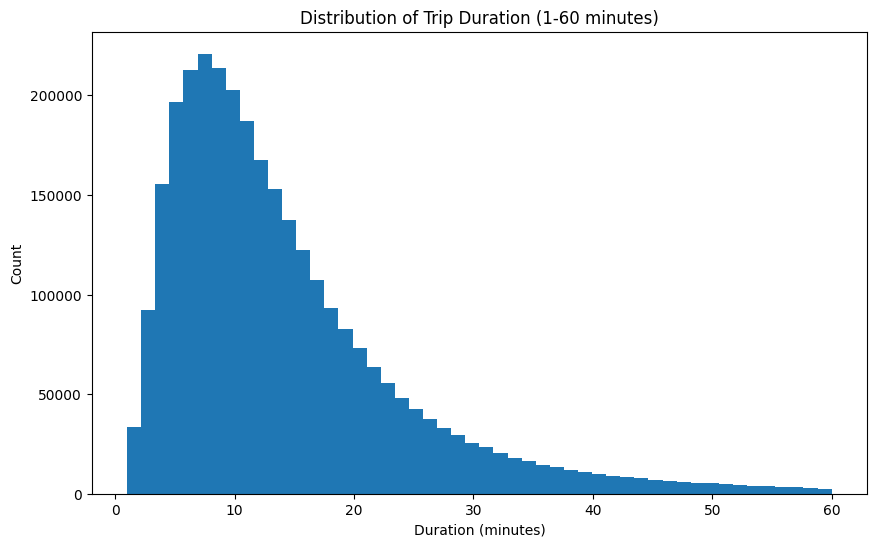

In [45]:
# Next, we need to check the distribution of the duration variable.
#  There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
# What fraction of the records left after you dropped the outliers?

# Get total records before filtering
total_records = len(df)

# Filter for durations between 1 and 60 minutes
df_filtered = df[(df.duration >= 1) & (df.duration <= 60)]

# Get remaining records after filtering
remaining_records = len(df_filtered)

# Calculate and print the fraction of records remaining
fraction_remaining = remaining_records / total_records
print(f"Fraction of records remaining after filtering: {fraction_remaining:.2%}")

# Show distribution plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df_filtered.duration, bins=50)
plt.title('Distribution of Trip Duration (1-60 minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Count')
plt.show()


# Q4. One-hot encoding

In [46]:
#Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

#Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will label encode them)
#Fit a dictionary vectorizer
#Get a feature matrix from it

categorical = ['PULocationID', 'DOLocationID']
numerical = ['duration']

df[categorical] = df[categorical].astype(str)

df = df[df.duration >= 1]
df = df[df.duration <= 60]

train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

X_train.shape

(3009173, 515)

# Q5. Training a model

In [47]:
#Train a plain linear regression model with default parameters, where duration is the response variable
#Calculate the RMSE of the model on the training data

# Train linear regression model
lr = LinearRegression()
y_train = df['duration'].values
lr.fit(X_train, y_train)

# Calculate RMSE on training data
y_pred = lr.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
print(f'RMSE on training data: {rmse:.2f}')



RMSE on training data: 7.65


# Q6. Evaluating the model

In [52]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [53]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [54]:
len(df_train), len(df_val)

(3009173, 2855951)

In [55]:
categorical = ['PULocationID', 'DOLocationID']

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [57]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [58]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.811813648526847